In [1]:
from tensorflow.keras import backend as K
K.clear_session()

In [2]:
import os
import splitfolders
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
from collections import Counter
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm  # Untuk progress ba
import seaborn as sns
from sklearn.metrics import confusion_matrix
from IPython.display import FileLink
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

Jumlah kelas: 14
Kelas yang tersedia: ['borage', 'calendula', 'chicory', 'coltsfoot', 'coneflower', 'cow_parsley', 'dandelion', 'fireweed', 'gardenia', 'geranium', 'harebell', 'henbit', 'knapweed', 'mullein']


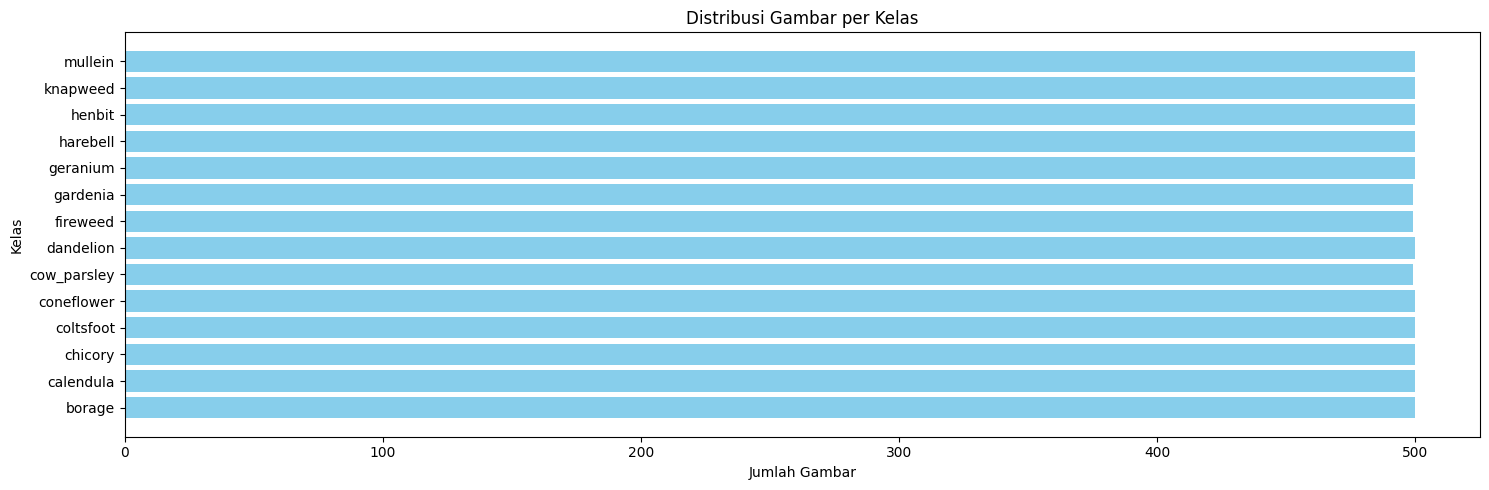

In [3]:
# Path dataset sebelum split
data_dir = r"D:\Deep Learning\dataset\14"
classes = os.listdir(data_dir)

# 1. Memahami Struktur Dataset
print(f"Jumlah kelas: {len(classes)}")
print(f"Kelas yang tersedia: {classes}")

# 2. Distribusi data
image_counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}

# Plot distribusi data dengan kelas di sumbu Y
plt.figure(figsize=(15, 5))  # Perbesar ukuran agar label terlihat
plt.barh(list(image_counts.keys()), list(image_counts.values()), color="skyblue")
plt.ylabel("Kelas")
plt.xlabel("Jumlah Gambar")
plt.title("Distribusi Gambar per Kelas")
plt.tight_layout()  # Mencegah teks terpotong
plt.show()

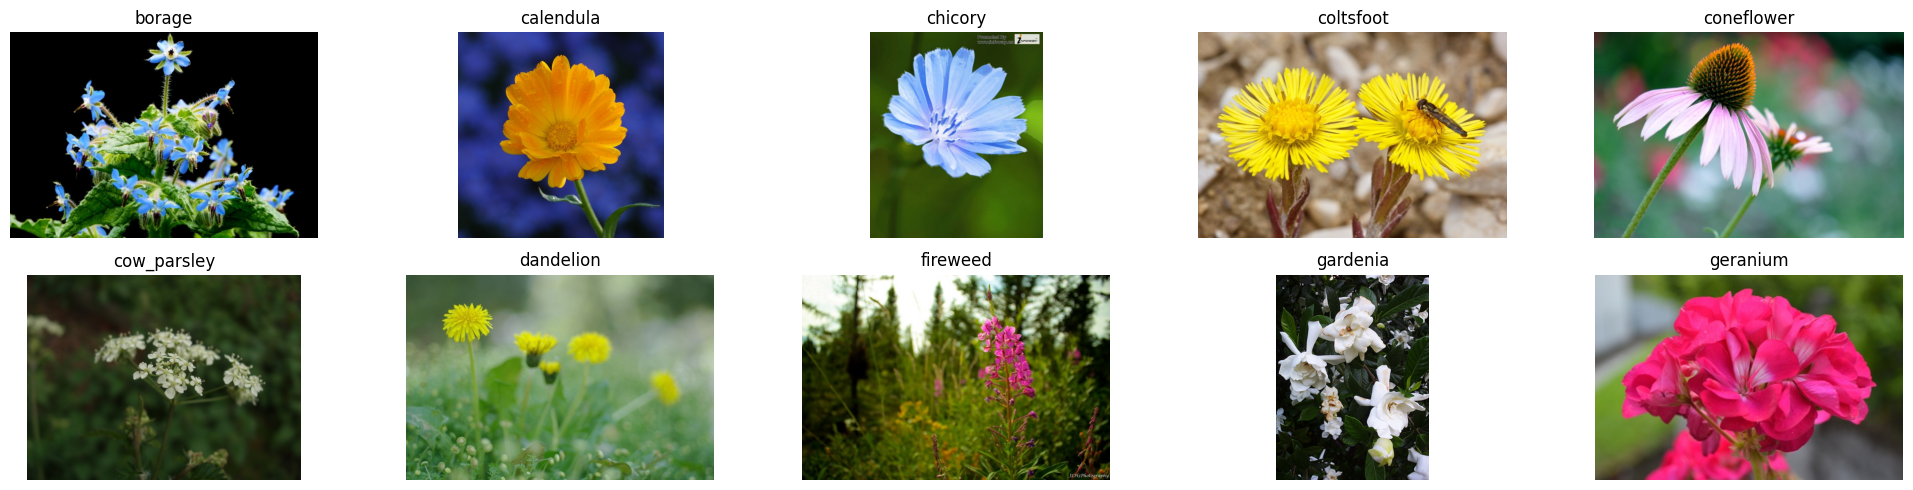

Ukuran gambar yang ditemukan: Counter({(400, 600): 4, (450, 600): 2, (600, 600): 1, (712, 600): 1, (399, 600): 1, (398, 600): 1, (808, 600): 1, (566, 600): 1, (449, 600): 1, (463, 600): 1})


In [4]:
# 3. Menampilkan Contoh Gambar
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 5))
for ax, cls in zip(axes.flatten(), classes):
    img_path = os.path.join(data_dir, cls, os.listdir(os.path.join(data_dir, cls))[0])
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis("off")
plt.tight_layout()
plt.show()

# 4. Menganalisis Ukuran Gambar
image_sizes = []
for cls in classes:
    img_path = os.path.join(data_dir, cls, os.listdir(os.path.join(data_dir, cls))[0])
    img = cv2.imread(img_path)
    image_sizes.append(img.shape[:2])
size_counts = Counter(image_sizes)
print("Ukuran gambar yang ditemukan:", size_counts)

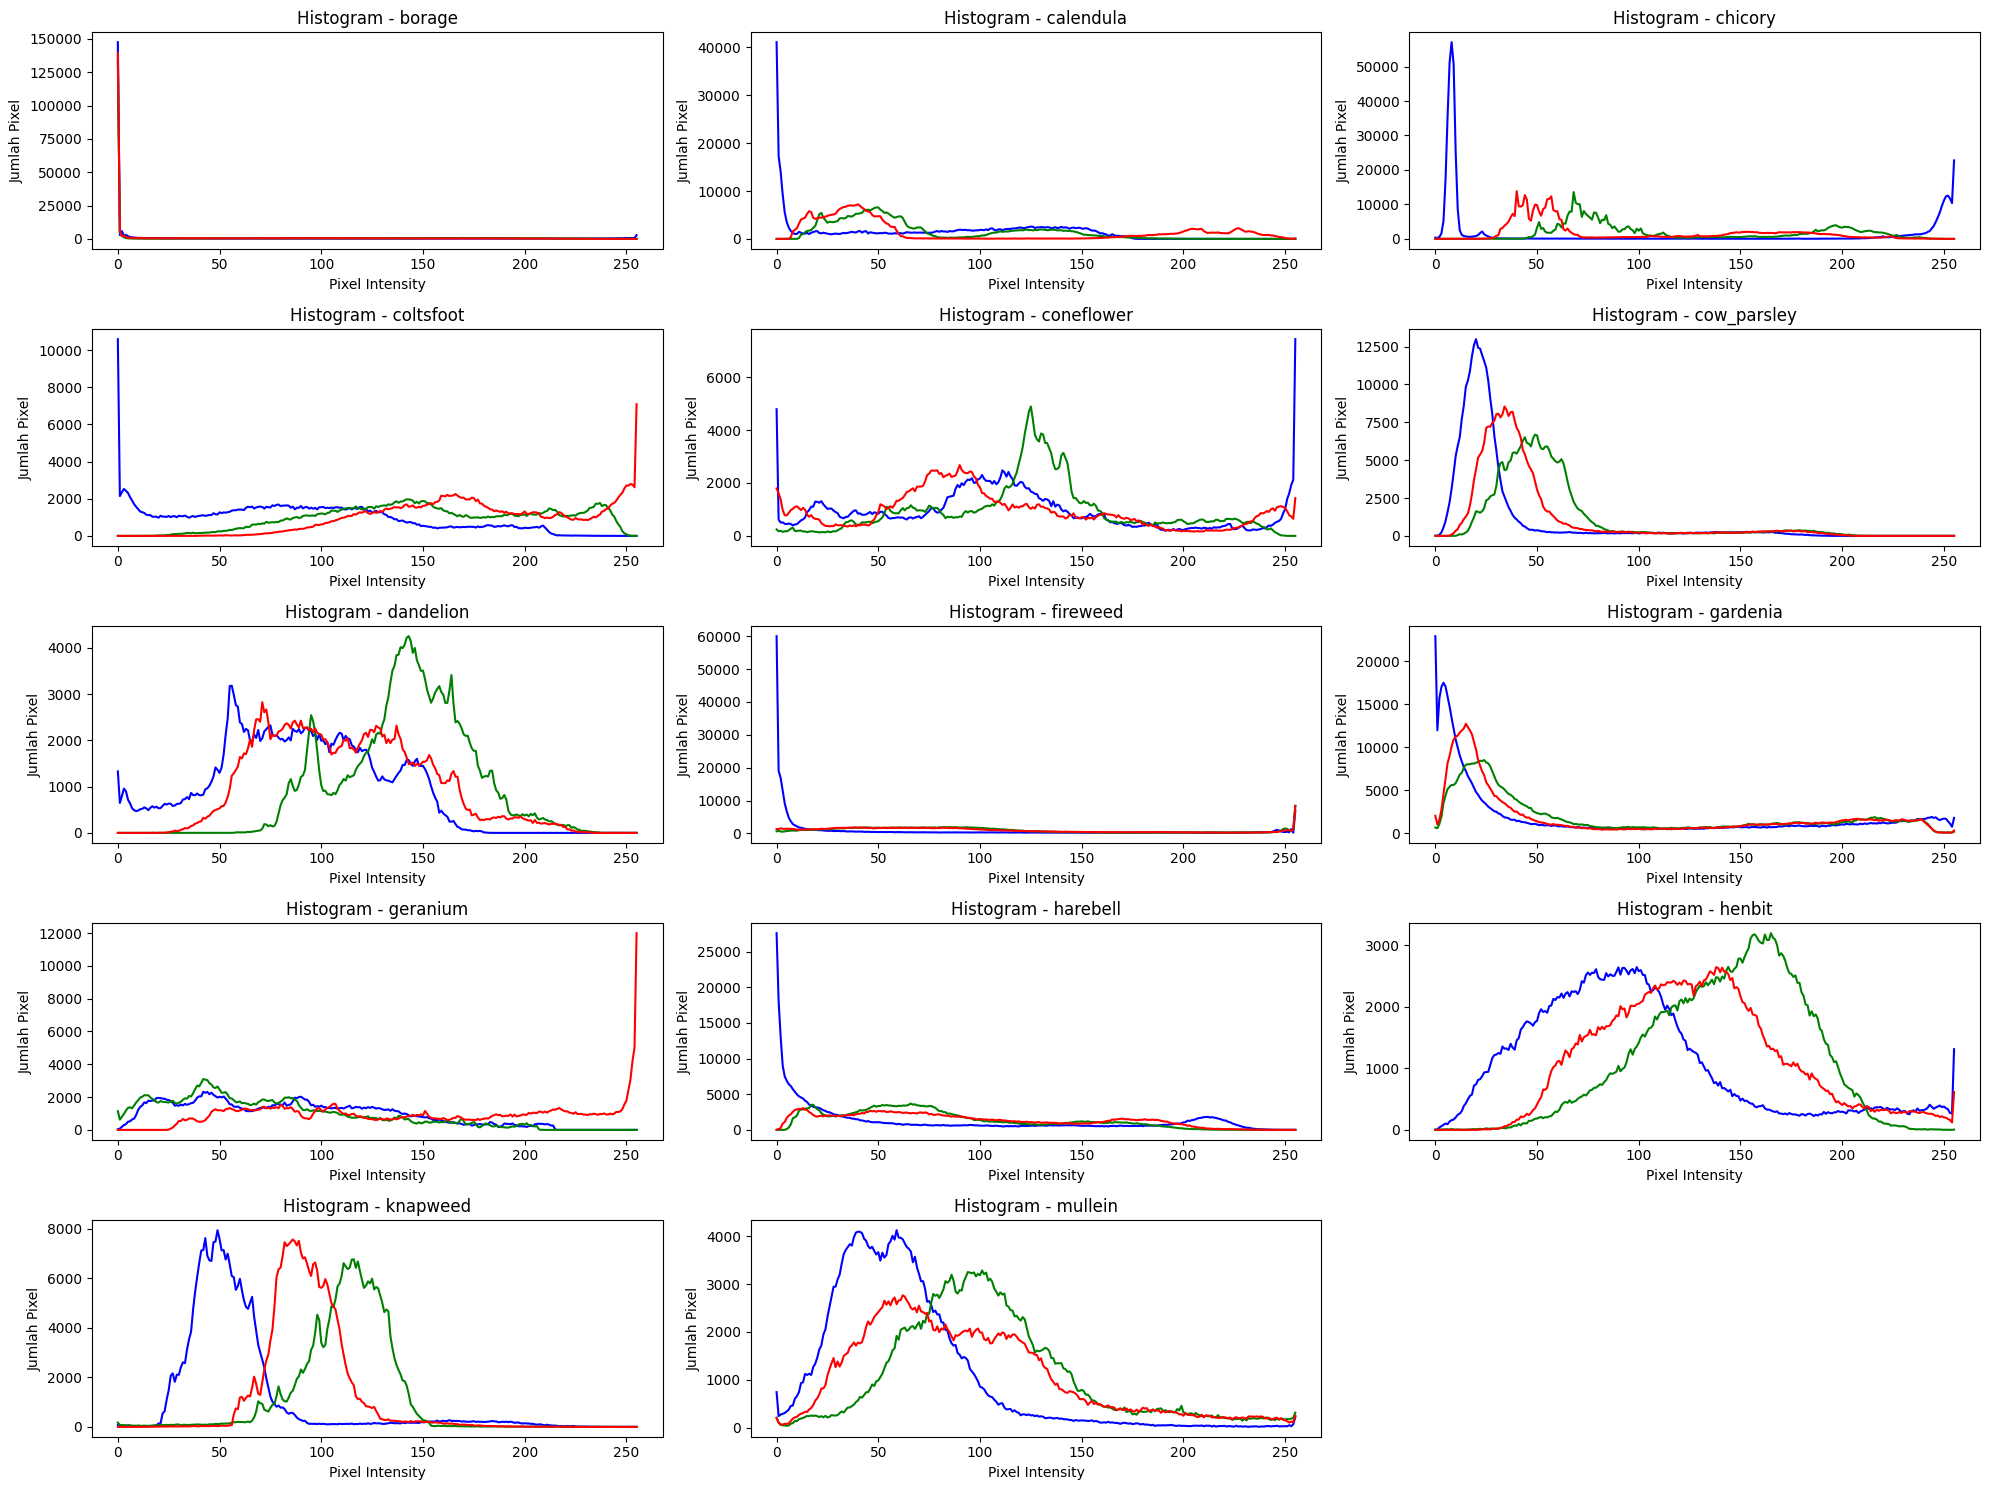

In [5]:
# Daftar kelas dalam dataset
num_classes = len(classes)
colors = ("blue", "green", "red")

# Ukuran grid subplot
cols = 3  # Banyaknya kolom
rows = (num_classes // cols) + (num_classes % cols > 0)  # Menghitung jumlah baris yang diperlukan

# Membuat plot
fig, axes = plt.subplots(rows, cols, figsize=(20, 3 * rows))
axes = axes.flatten()  # Ubah ke 1D agar mudah diakses dengan indeks

# Loop untuk setiap kelas
for idx, cls_sample in enumerate(classes):
    # Ambil satu contoh gambar dari kelas
    cls_path = os.path.join(data_dir, cls_sample)
    sample_img_path = os.path.join(cls_path, os.listdir(cls_path)[0])
    
    # Baca gambar
    sample_img = cv2.imread(sample_img_path)
    
    # Tampilkan histogram warna
    ax = axes[idx]
    for i, color in enumerate(colors):
        hist = cv2.calcHist([sample_img], [i], None, [256], [0, 256])
        ax.plot(hist, color=color)
    
    ax.set_title(f"Histogram - {cls_sample}")
    ax.set_xlabel("Pixel Intensity")
    ax.set_ylabel("Jumlah Pixel")

# Hapus subplot kosong jika jumlah kelas tidak habis dibagi jumlah kolom
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [6]:
# Direktori asli tempat dataset berada
data = data_dir
base_dir = r"D:\Deep Learning\dataset\14_split"  # Folder baru untuk menyimpan hasil split

# Buat folder train, val, test
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_dir, split), exist_ok=True)

classes = os.listdir(data_dir)

# Membagi dataset
for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    images = os.listdir(cls_path)

    # Split dataset: 80% train, 10% val, 10% test
    train_files, temp_files = train_test_split(images, test_size=0.2, random_state=12)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=12)

    # Buat folder kelas di setiap split
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

    # Pindahkan file ke masing-masing folder
    for file in train_files:
        shutil.copy(os.path.join(cls_path, file), os.path.join(base_dir, "train", cls))
    for file in val_files:
        shutil.copy(os.path.join(cls_path, file), os.path.join(base_dir, "val", cls))
    for file in test_files:
        shutil.copy(os.path.join(cls_path, file), os.path.join(base_dir, "test", cls))

print("Dataset berhasil dibagi menjadi train, val, dan test!")

Dataset berhasil dibagi menjadi train, val, dan test!


In [7]:
# Direktori utama dataset yang sudah dipisah
dirs = {
    "train": os.path.join(base_dir, 'train'),
    "val": os.path.join(base_dir, 'val'),
    "test": os.path.join(base_dir, 'test')
}
classes = [
    'geranium', 'gardenia', 'dandelion', 'coneflower', 'harebell', 'mullein', 'henbit', 'knapweed', 'cow_parsley', 'fireweed', 'chicory', 'calendula', 'coltsfoot', 'borage'
]
# Menghitung jumlah data di setiap kategori (train, val, test)
data_count = {"train": {}, "val": {}, "test": {}}

for dtype in dirs:
    for cls in classes:
        path = os.path.join(dirs[dtype], cls)
        data_count[dtype][cls] = len(os.listdir(path)) if os.path.exists(path) else 0

# Menghitung total data di setiap kategori
total_train = sum(data_count["train"].values())
total_val = sum(data_count["val"].values())
total_test = sum(data_count["test"].values())

# Membuat DataFrame untuk tabel
df = pd.DataFrame({
    "Kelas": classes,
    "Train": [data_count["train"][cls] for cls in classes],
    "Validation": [data_count["val"][cls] for cls in classes],
    "Test": [data_count["test"][cls] for cls in classes]
})

# Menambahkan total di akhir tabel
df.loc["Total"] = ["Total", total_train, total_val, total_test]

# Menampilkan tabel
print(df)

             Kelas  Train  Validation  Test
0         geranium    400          50    50
1         gardenia    399          50    50
2        dandelion    400          50    50
3       coneflower    400          50    50
4         harebell    400          50    50
5          mullein    400          50    50
6           henbit    400          50    50
7         knapweed    400          50    50
8      cow_parsley    399          50    50
9         fireweed    399          50    50
10         chicory    400          50    50
11       calendula    400          50    50
12       coltsfoot    400          50    50
13          borage    400          50    50
Total        Total   5597         700   700


In [8]:
# Ukuran gambar
img = (224, 224)
image_size = (224, 224, 3)
batcz = 16

train_datagen = ImageDataGenerator(
rescale=1./255,
brightness_range=[0.9, 1.1],
shear_range=0.15,
zoom_range=0.15,
rotation_range=15,
horizontal_flip=True,
fill_mode='nearest',
)


validation_datagen = ImageDataGenerator(
rescale=1./255,
)

test_datagen = ImageDataGenerator(
rescale=1./255,
)

train_generator = train_datagen.flow_from_directory(
os.path.join(base_dir, 'train'),
target_size=(img),
batch_size=batcz,
class_mode='categorical',
shuffle=True,
)

validation_generator = validation_datagen.flow_from_directory(
os.path.join(base_dir, 'val'),
target_size=(img),
batch_size=batcz,
class_mode='categorical',
shuffle=False,
)

test_generator = test_datagen.flow_from_directory(
os.path.join(base_dir, 'test'),
target_size=(img),
batch_size=batcz,
class_mode='categorical',
shuffle=False,
)

Found 5597 images belonging to 14 classes.
Found 700 images belonging to 14 classes.
Found 700 images belonging to 14 classes.


In [9]:
# Pastikan ukuran gambar sesuai
image_size = (224, 224, 3)  # Gantilah sesuai dengan dataset

model = Sequential([
    # Layer Konvolusi 1
    Conv2D(64, (5,5), activation='relu', input_shape=image_size),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Layer Konvolusi 2
    Conv2D(64, (5,5), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Layer Konvolusi 3
    Conv2D(128, (5,5), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Layer Konvolusi 4
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Layer Konvolusi 5 (meningkatkan kompleksitas model)
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Flatten untuk mengubah ke bentuk vektor
    Flatten(),

    # # Fully Connected Layer dengan L2 Regularization
    # Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    # Dropout(0.5),

    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    Dense(14, activation='softmax')  # Output layer sesuai jumlah kelas
])

# Menampilkan arsitektur model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 64)      102464    
                                                                 
 batch_normalization_1 (Batc  (None, 106, 106, 64)     256       
 hNormalization)                                                 
                                                        

In [10]:
# Learning rate scheduler (turun otomatis jika model tidak membaik)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor nilai loss pada validation set
    factor=0.1,  # Learning rate akan dikurangi 50% jika tidak ada perbaikan
    patience=3,  # Turunkan jika tidak ada peningkatan dalam 3 epoch
    min_lr= 0.000001  # Learning rate minimum
)

# Kompilasi model dengan Adam yang telah diperbarui
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping untuk menghentikan training jika model sudah stabil
early_stop = EarlyStopping(
    monitor='val_loss',        
    patience=5,               
    restore_best_weights=True  
)

# Training model dengan Learning Rate Scheduler
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=1000,  # Set angka besar agar training terus berjalan
    callbacks=[early_stop, lr_scheduler]  # Tambahkan Learning Rate Scheduler
)


Epoch 1/1000
350/350 [==============================] - 125s 332ms/step - loss: 3.0075 - accuracy: 0.3075 - val_loss: 2.8833 - val_accuracy: 0.2957 - lr: 0.0010
Epoch 2/1000
350/350 [==============================] - 59s 169ms/step - loss: 2.1776 - accuracy: 0.4390 - val_loss: 1.9605 - val_accuracy: 0.4943 - lr: 0.0010
Epoch 3/1000
350/350 [==============================] - 55s 158ms/step - loss: 1.9113 - accuracy: 0.5137 - val_loss: 2.3922 - val_accuracy: 0.4057 - lr: 0.0010
Epoch 4/1000
350/350 [==============================] - 54s 154ms/step - loss: 1.7073 - accuracy: 0.5565 - val_loss: 1.6683 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 5/1000
350/350 [==============================] - 57s 164ms/step - loss: 1.5446 - accuracy: 0.5966 - val_loss: 1.7084 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 6/1000
350/350 [==============================] - 57s 163ms/step - loss: 1.4852 - accuracy: 0.6025 - val_loss: 1.5090 - val_accuracy: 0.6014 - lr: 0.0010
Epoch 7/1000
350/350 [=================

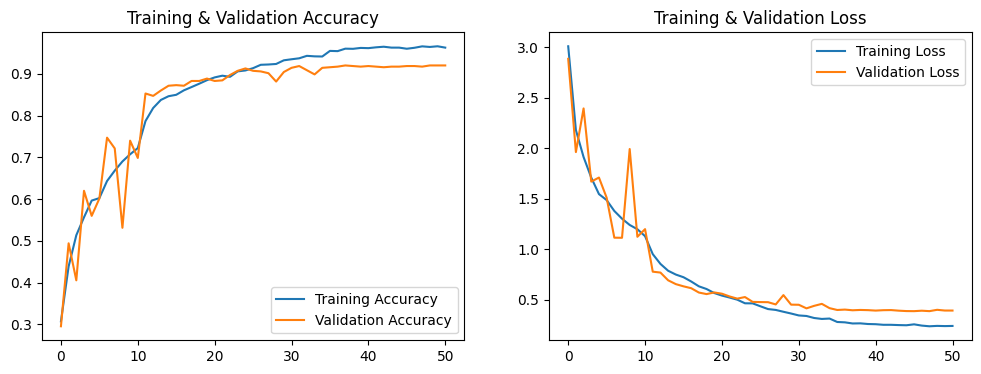

In [11]:
# Plot akurasi dan loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()


In [12]:
# Prediksi pada data validasi
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes


class_report = classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys())
print("Classification Report:\n", class_report)

44/44 [==============================] - 4s 88ms/step
Classification Report:
               precision    recall  f1-score   support

      borage       0.91      0.80      0.85        50
   calendula       0.86      0.86      0.86        50
     chicory       0.96      0.98      0.97        50
   coltsfoot       0.96      0.98      0.97        50
  coneflower       0.94      0.92      0.93        50
 cow_parsley       0.86      1.00      0.93        50
   dandelion       0.95      0.84      0.89        50
    fireweed       0.98      0.92      0.95        50
    gardenia       0.96      0.94      0.95        50
    geranium       0.87      0.92      0.89        50
    harebell       0.83      0.88      0.85        50
      henbit       0.90      0.90      0.90        50
    knapweed       0.98      0.98      0.98        50
     mullein       0.92      0.94      0.93        50

    accuracy                           0.92       700
   macro avg       0.92      0.92      0.92       700
we

44/44 [==============================] - 2s 53ms/step


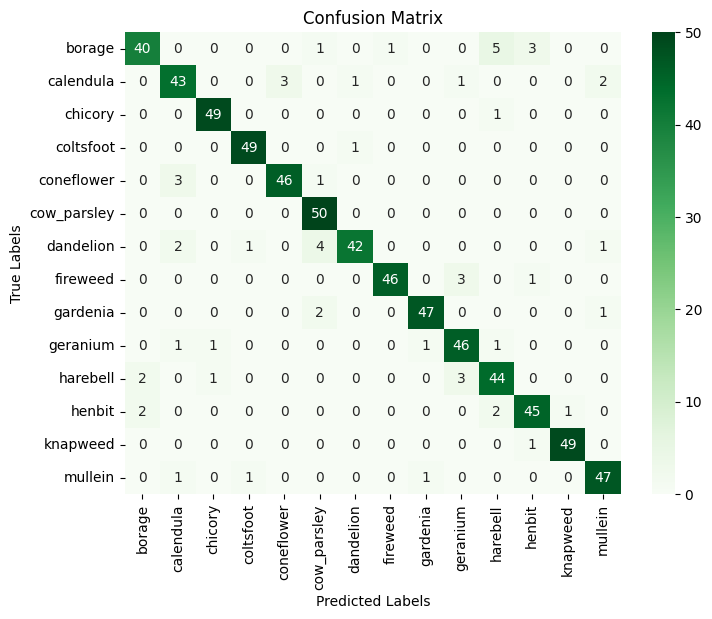

In [13]:
true_labels = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(true_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Evaluasi akurasi dan loss pada dataset training, validasi dan test
train_loss, train_acc = model.evaluate(train_generator)
print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Train Loss: {train_loss:.4f}\n")

val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}\n")

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


350/350 [==============================] - 48s 137ms/step - loss: 0.1681 - accuracy: 0.9918
Train Accuracy: 99.18%
Train Loss: 0.1681

44/44 [==============================] - 3s 58ms/step - loss: 0.3861 - accuracy: 0.9186
Validation Accuracy: 91.86%
Validation Loss: 0.3861

44/44 [==============================] - 8s 190ms/step - loss: 0.3856 - accuracy: 0.9257
Test Accuracy: 92.57%
Test Loss: 0.3856


In [15]:
model.save("model_cnn_94_new.h5")  # Simpan model
shutil.move("model_cnn_94_new.h5", "./model_cnn_94_new.h5")  # Pastikan di root directory

# Buat link download
FileLink("model_cnn_94_new.h5")


d:\Deep Learning\model_cnn_94_new.h5

1/1 [==============================] - 0s 417ms/step


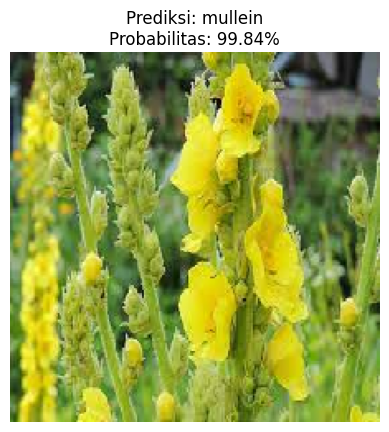

Model memprediksi: mullein dengan probabilitas 99.84%


In [16]:
# 1️⃣ **Load Model yang Sudah Dilatih**
model_path = r"D:\Deep Learning\model_cnn_94_new.h5"  # Pastikan path sesuai lokasi model
# Pastikan model_cnn.h5 sudah di-download ulang atau di-save ulang dengan benar
model = load_model(model_path)

# 2️⃣ **Daftar Kelas Sesuai Dataset Latihan**
class_labels = ['borage', 'calendula', 'chicory', 'coltsfoot', 'coneflower', 
                'cow_parsley', 'dandelion', 'fireweed', 'gardenia', 'geranium', 
                'harebell', 'henbit', 'knapweed', 'mullein']  # Sesuaikan dengan dataset

# 3️⃣ **Path ke Gambar yang Ingin Diprediksi**
path_test = r"D:\Deep Learning\testing\images.jpeg"  # Ubah sesuai gambar uji

# 4️⃣ **Preprocessing Gambar**
img = image.load_img(path_test, target_size=(224, 224))  # Sesuaikan ukuran gambar
img_array = image.img_to_array(img)  # Konversi ke array
img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
img_array /= 255.0  # Normalisasi nilai piksel

# 5️⃣ **Prediksi Menggunakan Model**
predictions = model.predict(img_array)  # Hasil probabilitas setiap kelas
predicted_class = np.argmax(predictions)  # Kelas dengan probabilitas tertinggi
confidence = np.max(predictions) * 100  # Probabilitas dalam persen

# 6️⃣ **Menampilkan Hasil Prediksi**
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediksi: {class_labels[predicted_class]}\nProbabilitas: {confidence:.2f}%")
plt.show()

print(f"Model memprediksi: {class_labels[predicted_class]} dengan probabilitas {confidence:.2f}%")

1/1 [==============================] - 0s 104ms/step


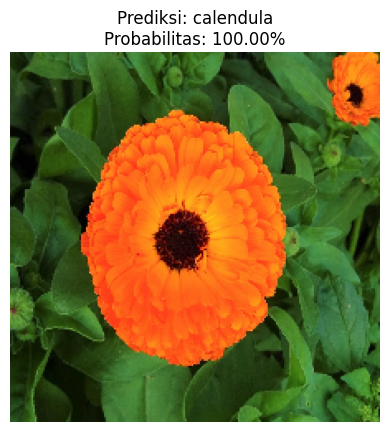

Model memprediksi: calendula dengan probabilitas 100.00%


In [17]:
# 1️⃣ **Load Model yang Sudah Dilatih**
model_path = r"D:\Deep Learning\model_cnn_94_new.h5"  # Pastikan path sesuai lokasi model
# Pastikan model_cnn.h5 sudah di-download ulang atau di-save ulang dengan benar
model = load_model(model_path)

# 2️⃣ **Daftar Kelas Sesuai Dataset Latihan**
class_labels = ['borage', 'calendula', 'chicory', 'coltsfoot', 'coneflower', 
                'cow_parsley', 'dandelion', 'fireweed', 'gardenia', 'geranium', 
                'harebell', 'henbit', 'knapweed', 'mullein']  # Sesuaikan dengan dataset

# 3️⃣ **Path ke Gambar yang Ingin Diprediksi**
path_test = r"D:\Deep Learning\testing\1200px-Pot_marigold.jpg"  # Ubah sesuai gambar uji

# 4️⃣ **Preprocessing Gambar**
img = image.load_img(path_test, target_size=(224, 224))  # Sesuaikan ukuran gambar
img_array = image.img_to_array(img)  # Konversi ke array
img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
img_array /= 255.0  # Normalisasi nilai piksel

# 5️⃣ **Prediksi Menggunakan Model**
predictions = model.predict(img_array)  # Hasil probabilitas setiap kelas
predicted_class = np.argmax(predictions)  # Kelas dengan probabilitas tertinggi
confidence = np.max(predictions) * 100  # Probabilitas dalam persen

# 6️⃣ **Menampilkan Hasil Prediksi**
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediksi: {class_labels[predicted_class]}\nProbabilitas: {confidence:.2f}%")
plt.show()

print(f"Model memprediksi: {class_labels[predicted_class]} dengan probabilitas {confidence:.2f}%")

1/1 [==============================] - 0s 108ms/step


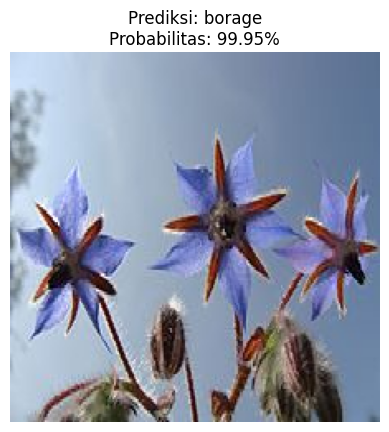

Model memprediksi: borage dengan probabilitas 99.95%


In [18]:
# 1️⃣ **Load Model yang Sudah Dilatih**
model_path = r"D:\Deep Learning\model_cnn_94_new.h5"  # Pastikan path sesuai lokasi model
# Pastikan model_cnn.h5 sudah di-download ulang atau di-save ulang dengan benar
model = load_model(model_path)

# 2️⃣ **Daftar Kelas Sesuai Dataset Latihan**
class_labels = ['borage', 'calendula', 'chicory', 'coltsfoot', 'coneflower', 
                'cow_parsley', 'dandelion', 'fireweed', 'gardenia', 'geranium', 
                'harebell', 'henbit', 'knapweed', 'mullein']  # Sesuaikan dengan dataset

# 3️⃣ **Path ke Gambar yang Ingin Diprediksi**
path_test = r"D:\Deep Learning\testing\Borage_starflower_Rohtopurasruoho_01.jpg"  # Ubah sesuai gambar uji

# 4️⃣ **Preprocessing Gambar**
img = image.load_img(path_test, target_size=(224, 224))  # Sesuaikan ukuran gambar
img_array = image.img_to_array(img)  # Konversi ke array
img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
img_array /= 255.0  # Normalisasi nilai piksel

# 5️⃣ **Prediksi Menggunakan Model**
predictions = model.predict(img_array)  # Hasil probabilitas setiap kelas
predicted_class = np.argmax(predictions)  # Kelas dengan probabilitas tertinggi
confidence = np.max(predictions) * 100  # Probabilitas dalam persen

# 6️⃣ **Menampilkan Hasil Prediksi**
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediksi: {class_labels[predicted_class]}\nProbabilitas: {confidence:.2f}%")
plt.show()

print(f"Model memprediksi: {class_labels[predicted_class]} dengan probabilitas {confidence:.2f}%")

1/1 [==============================] - 0s 101ms/step


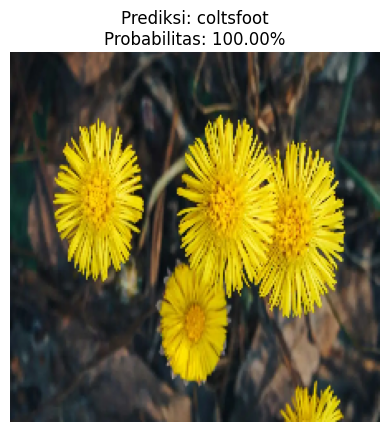

Model memprediksi: coltsfoot dengan probabilitas 100.00%


In [19]:
# 1️⃣ **Load Model yang Sudah Dilatih**
model_path = r"D:\Deep Learning\model_cnn_94_new.h5"  # Pastikan path sesuai lokasi model
# Pastikan model_cnn.h5 sudah di-download ulang atau di-save ulang dengan benar
model = load_model(model_path)

# 2️⃣ **Daftar Kelas Sesuai Dataset Latihan**
class_labels = ['borage', 'calendula', 'chicory', 'coltsfoot', 'coneflower', 
                'cow_parsley', 'dandelion', 'fireweed', 'gardenia', 'geranium', 
                'harebell', 'henbit', 'knapweed', 'mullein']  # Sesuaikan dengan dataset

# 3️⃣ **Path ke Gambar yang Ingin Diprediksi**
path_test = r"D:\Deep Learning\testing\coltsfoot-1296x728-feature.webp"  # Ubah sesuai gambar uji

# 4️⃣ **Preprocessing Gambar**
img = image.load_img(path_test, target_size=(224, 224))  # Sesuaikan ukuran gambar
img_array = image.img_to_array(img)  # Konversi ke array
img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
img_array /= 255.0  # Normalisasi nilai piksel

# 5️⃣ **Prediksi Menggunakan Model**
predictions = model.predict(img_array)  # Hasil probabilitas setiap kelas
predicted_class = np.argmax(predictions)  # Kelas dengan probabilitas tertinggi
confidence = np.max(predictions) * 100  # Probabilitas dalam persen

# 6️⃣ **Menampilkan Hasil Prediksi**
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediksi: {class_labels[predicted_class]}\nProbabilitas: {confidence:.2f}%")
plt.show()

print(f"Model memprediksi: {class_labels[predicted_class]} dengan probabilitas {confidence:.2f}%")

1/1 [==============================] - 0s 100ms/step


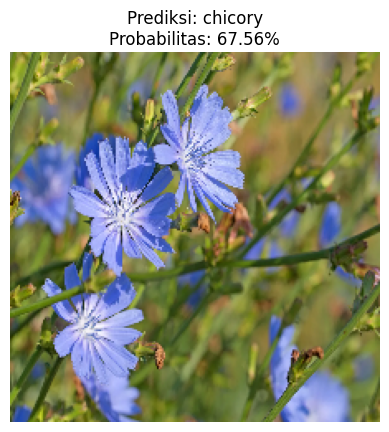

Model memprediksi: chicory dengan probabilitas 67.56%


In [20]:
# 1️⃣ **Load Model yang Sudah Dilatih**
model_path = r"D:\Deep Learning\model_cnn_94_new.h5"  # Pastikan path sesuai lokasi model
# Pastikan model_cnn.h5 sudah di-download ulang atau di-save ulang dengan benar
model = load_model(model_path)

# 2️⃣ **Daftar Kelas Sesuai Dataset Latihan**
class_labels = ['borage', 'calendula', 'chicory', 'coltsfoot', 'coneflower', 
                'cow_parsley', 'dandelion', 'fireweed', 'gardenia', 'geranium', 
                'harebell', 'henbit', 'knapweed', 'mullein']  # Sesuaikan dengan dataset

# 3️⃣ **Path ke Gambar yang Ingin Diprediksi**
path_test = r"D:\Deep Learning\testing\Flowers-stems-chicory.webp"  # Ubah sesuai gambar uji

# 4️⃣ **Preprocessing Gambar**
img = image.load_img(path_test, target_size=(224, 224))  # Sesuaikan ukuran gambar
img_array = image.img_to_array(img)  # Konversi ke array
img_array = np.expand_dims(img_array, axis=0)  # Tambahkan dimensi batch
img_array /= 255.0  # Normalisasi nilai piksel

# 5️⃣ **Prediksi Menggunakan Model**
predictions = model.predict(img_array)  # Hasil probabilitas setiap kelas
predicted_class = np.argmax(predictions)  # Kelas dengan probabilitas tertinggi
confidence = np.max(predictions) * 100  # Probabilitas dalam persen

# 6️⃣ **Menampilkan Hasil Prediksi**
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediksi: {class_labels[predicted_class]}\nProbabilitas: {confidence:.2f}%")
plt.show()

print(f"Model memprediksi: {class_labels[predicted_class]} dengan probabilitas {confidence:.2f}%")